In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='@shakti28',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:/Data Science Portfolio Project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

# establishing connection to mysql database
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "@shakti28",
                            database = "ecommerce")

# A cursor is used to run SQL queries and get results from the database.
# Uses of a cursor:
# 1. Execute SQL queries (e.g., SELECT, INSERT, UPDATE).
# 2. Fetch results from queries.
# 3. Iterate through query results.
# 4. Manage database transactions.

cur = db.cursor()

# BASIC QUERIES TASKS

## Task 1: List all unique cities where customers are located.

In [ ]:
# This query retrieves all unique customer cities:
# 1. Selects distinct 'customer_city' values from the 'customers' table.
# 2. Ensures no duplicate city names are included in the result.

query1 = """ select distinct customer_city from customers """

# executes query
cur.execute(query1)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()

data

## Task 2: Count the number of orders placed in 2017.

In [ ]:
# This query counts the total number of orders placed in the year 2017:
# 1. Filters rows in the 'orders' table where the 'order_purchase_timestamp' is in 2017.
# 2. Counts the number of matching 'order_id' values.

query2 = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

# executes query
cur.execute(query2)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()

"Total orders placed in 2017 are: ",data[0][0]

## Task 3: Find the total sales per category.

In [ ]:
# This query calculates total sales for each product category:
# 1. Joins 'products', 'order_items', and 'payments' tables based on matching product and order IDs.
# 2. Sums up 'payment_value' for each 'product_category'.
# 3. Groups the results by 'product_category'.
# 4. Rounds the total sales to two decimal places and labels it as 'sales'.

query3 = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

# executes query
cur.execute(query3)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Category","Sales"])
df

## Task 4: Calculate the percentage of orders that were paid in installments.

In [ ]:
# This query calculates the percentage of payments with at least one installment:
# 1. Counts rows where 'payment_installments' is 1 or more using a CASE statement.
# 2. Divides this count by the total number of rows in the 'payments' table.
# 3. Multiplies the result by 100 to get the percentage.

query4 = """ select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*)*100
from payments
"""

# executes query
cur.execute(query4)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()

data

## Task 5: Count the number of customers from each state.

In [ ]:
# This query counts the number of customers in each state:
# 1. Selects 'customer_state' and the count of 'customer_id'.
# 2. Groups the results by 'customer_state'.
# 3. Returns the customer count for each state.

query4 = """ select customer_state, count(customer_id)
from customers
group by customer_state 
"""

# executes query
cur.execute(query4)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()

# This code creates and sorts a DataFrame:
# 1. Creates a DataFrame 'df' with columns "State" and "Total Customers" from 'data'.
# 2. Sorts 'df' by the "Total Customers" column in descending order (highest to lowest).

df = pd.DataFrame(data,columns = ["State","Total Customers"])
df = df.sort_values(by = "Total Customers", ascending=False)

# This code creates a bar chart:
# 1. Uses 'State' column from the DataFrame 'df' for the x-axis.
# 2. Uses 'Total Customers' column for the heights of the bars.
# 3. Displays the bar chart with plt.show().

plt.figure(figsize=(10,4))
plt.bar(df["State"],df["Total Customers"])
plt.xticks(rotation = 45)
plt.show()

# Intermediate Queries Tasks

## Task 6: Calculate the number of orders per month in 2018.

In [ ]:
# This query counts the number of orders placed in each month of 2018:
# 1. Extracts the month name from 'order_purchase_timestamp' and labels it as 'months'.
# 2. Filters rows where the year is 2018.
# 3. Counts the 'order_id' values for each month.
# 4. Groups the results by 'months'.

query6 = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

# executes query
cur.execute(query6)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months","Total Orders"])
df

months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

# This code creates a bar plot with labels:
# 1. Uses Seaborn's barplot function to plot 'Total Orders' against 'Months' from the DataFrame 'df'.
# 2. Orders the bars based on the 'months' list.
# 3. Rotates the x-axis labels by 45 degrees for better readability.
# 4. Adds labels on top of the bars showing the exact count of 'Total Orders'.
# 5. Displays the plot with plt.show().

ax = sns.barplot(x=df["Months"], y=df["Total Orders"], data=df, order=months)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

## Task 7: Find the average number of products per order, grouped by customer city.

In [ ]:
# This query calculates the average number of items per order for each customer city:
# 1. Creates a Common Table Expression (CTE) 'count_per_order':
#    - Joins 'orders' and 'order_items' to count the number of items ('oc') per order.
#    - Groups the count by 'order_id' and 'customer_id'.
# 2. Joins the 'customers' table with the CTE on 'customer_id'.
# 3. Groups the results by 'customer_city'.
# 4. Calculates the average number of items ('oc') per order for each city.

query7 = """ 
with count_per_order as 
(select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city , round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc
"""

# executes query
cur.execute(query7)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["City","Average Orders"])
df.head(10)

## Task 8: Calculate the percentage of total revenue contributed by each product category.

In [ ]:
# This query calculates the percentage of total sales contributed by each product category:
# 1. Converts 'product_category' to uppercase and labels it as 'category'.
# 2. Calculates the total sales for each category as a percentage of overall sales.
#    - Sums 'payment_value' for each category.
#    - Divides it by the total sum of 'payment_value' from the 'payments' table.
#    - Multiplies by 100 and rounds to two decimal places.
# 3. Groups the results by 'category'.
# 4. Sorts the categories in descending order of sales percentage.

query8 = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_per 
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category 
order by sales_per desc
"""

# executes query
cur.execute(query8)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Sales Percentage"])
df.head(10)

## Task 9: Identify the correlation between product price and the number of times a product has been purchased.

In [4]:
# This query retrieves product category statistics:
# 1. Selects the 'product_category' from the 'products' table.
# 2. Counts the number of products sold ('product_id') in each category.
# 3. Calculates the average price of products in each category, rounded to two decimal places.
# 4. Joins the 'products' and 'order_items' tables on 'product_id'.
# 5. Groups the results by 'product_category'.

query9 = """
select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

# executes query
cur.execute(query9)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category","Total_Orders","Avg_Price"])
df.head(10)

# This code calculates the correlation between total orders and average price:
# 1. Extracts 'Total_Orders' and 'Avg_Price' columns from the DataFrame 'df' as arrays 'arr1' and 'arr2'.
# 2. Computes the Pearson correlation coefficient matrix using numpy's corrcoef function.
# 3. Prints the correlation value (c[0][1]) between 'Total_Orders' and 'Avg_Price'.

arr1 = df["Total_Orders"]
arr2 = df["Avg_Price"]
c = np.corrcoef(arr1,arr2)
print("The Correlation is: ",c[0][1])

The Correlation is:  -0.10631514167157562


## Task 10: Calculate the total revenue generated by each seller, and rank them by revenue.

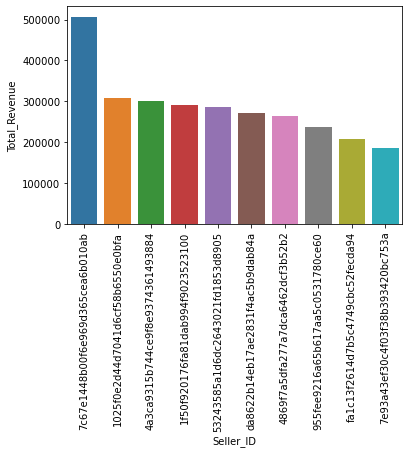

In [12]:
# This query ranks sellers based on their revenue:
# 1. Calculates the total revenue for each seller ('seller_id') by:
#    - Summing 'payment_value' from the 'payments' table for each 'order_id' in 'order_items'.
#    - Rounding the revenue to two decimal places.
#    - Grouping by 'seller_id'.
# 2. Creates a subquery 'a' to store the seller revenue data.
# 3. Uses the DENSE_RANK() window function to rank sellers in descending order of revenue.
# 4. Assigns the rank to a new column 'rn'.
# 5. Selects all columns from the subquery, along with the rank.

query10 = """
select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, round(sum(payments.payment_value),2)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

# executes query
cur.execute(query10)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Seller_ID","Total_Revenue","Ranks"])
df = df.head(10)

sns.barplot(x = "Seller_ID", y = "Total_Revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Advance Queries Tasks

## Task 11: Calculate the moving average of order values for each customer over their order history.

In [18]:
# Moving average: The average of the current value and recent values.

# This query calculates a moving average of payments for each customer:
# 1. Joins 'payments' and 'orders' tables on 'order_id' to select:
#    - 'customer_id', 'order_purchase_timestamp', and 'payment_value' (renamed as 'payment').
#    - Stores this data in a subquery 'a'.
# 2. Computes a moving average ('mov_avg') of payments:
#    - Partitions the data by 'customer_id' to calculate averages for each customer separately.
#    - Orders the data by 'order_purchase_timestamp'.
#    - Includes the current row and the two preceding rows in the calculation.
# 3. Selects 'customer_id', 'order_purchase_timestamp', 'payment', and the calculated moving average.

query11 = """
select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a
"""

# executes query
cur.execute(query11)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Order_ID","Order_Timestamp","Order_Price","Moving_Avg"])
df.head(40)

,Order_ID,Order_Timestamp,Order_Price,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


## Task 12: Calculate the cumulative sales per month for each year.

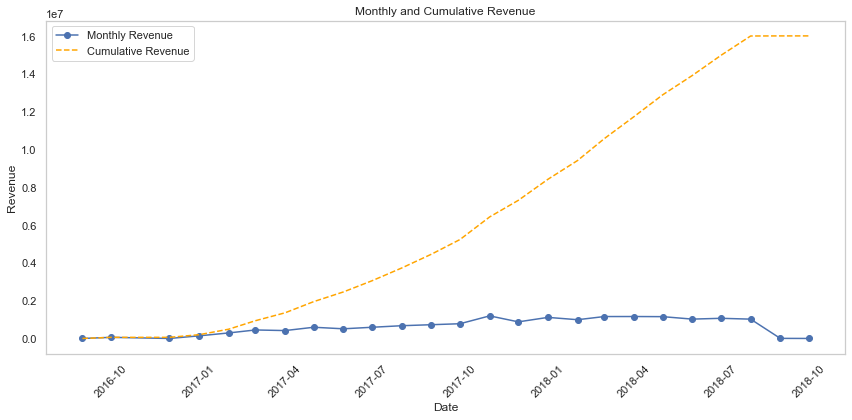

In [29]:
# This query calculates cumulative sales by year and month:
# 1. Joins 'orders' and 'payments' tables to calculate total payment per month:
#    - Extracts the year ('years') and month ('months') from 'order_purchase_timestamp'.
#    - Sums 'payment_value' for each (year, month) combination, rounded to two decimal places.
#    - Groups the results by 'years' and 'months'.
# 2. Uses the SUM() window function to calculate the cumulative sales:
#    - Orders the data by 'years' and 'months'.
#    - Computes the running total of 'payment' for each row.
# 3. Selects 'years', 'months', 'payment', and the cumulative sales ('cumulative_sales').

query12= """
select years, months, payment, sum(payment)
over(order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
""" 

# executes query
cur.execute(query12)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","Month","Monthly_Revenue","Cummulative_Revenue"])
df

# This code creates a line plot for monthly and cumulative revenue:
# 1. Converts 'Year' and 'Month' columns into a single 'Date' column for better visualization.
# 2. Plots 'Monthly_Revenue' and 'Cummulative_Revenue' against the 'Date':
#    - The 'Monthly_Revenue' is plotted with circles as markers.
#    - The 'Cummulative_Revenue' is plotted with a dashed orange line.
# 3. Adds title, labels, legend, and grid to the plot for clarity.
# 4. Rotates x-axis labels by 45 degrees for better readability.
# 5. Adjusts layout for a clean presentation and shows the plot.

# Convert Year and Month to a single datetime for better visualization
df['Date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Monthly_Revenue'], label='Monthly Revenue', marker='o')
plt.plot(df['Date'], df['Cummulative_Revenue'], label='Cumulative Revenue', linestyle='--', color='orange')
plt.title('Monthly and Cumulative Revenue')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Task 13: Calculate the year-over-year growth rate of total sales.

In [6]:
# This query calculates the year-over-year growth in payment value:
# 1. Creates a CTE(Common Table Expression) 'a' to calculate yearly payments:
#    - Extracts the year ('years') from 'order_purchase_timestamp'.
#    - Sums 'payment_value' for each year, rounded to two decimal places.
#    - Groups by 'years' and orders the results by year.
# 2. Computes the year-over-year growth:
#    - Uses the LAG() function to get the previous year's payment value.
#    - Subtracts the previous year's payment from the current year's payment.
#    - Divides by the previous year's payment and multiplies by 100 to get the percentage growth.
# 3. Selects 'years' and the calculated growth percentage.

query13 = """with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years)) *100
from a
"""

# executes query
cur.execute(query13)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","YOY_Growth%"])
df

,Year,YOY_Growth%
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


## Task 14:  Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [8]:
# This query calculates the percentage of customers who made repeat orders within 6 months:
# 1. CTE(Common Table Expression) 'a' identifies each customer's first order:
#    - Joins 'customers' and 'orders' tables on 'customer_id'.
#    - Finds the earliest 'order_purchase_timestamp' for each customer ('first_order').
#    - Groups by 'customer_id'.
# 2. CTE(Common Table Expression) 'b' counts subsequent orders:
#    - Joins 'a' with 'orders' to find orders placed by the customer after their first order.
#    - Filters orders made within 6 months of the 'first_order'.
#    - Counts distinct 'order_purchase_timestamp' values for each customer.
#    - Groups by 'customer_id'.
# 3. Final query:
#    - Performs a LEFT JOIN between 'a' and 'b' on 'customer_id'.
#    - Counts customers with at least one order in 'a' and those in 'b' (repeat orders).
#    - Calculates the percentage of customers who made repeat orders using the formula:
#      (Count of customers in 'b' / Total customers in 'a') * 100.

query14 = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id """


# executes query
cur.execute(query14)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
data

[(None,)]

## Task 15: Identify the top 3 customers who spent the most money in each year.

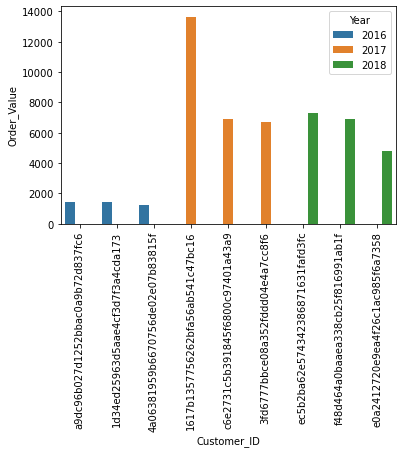

In [10]:
query15 = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 """

# executes query
cur.execute(query15)

# Retrieves all rows from the last executed SQL query and stores them in 'data'.
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year","Customer_ID","Order_Value","Rank"])
df

sns.barplot(x = "Customer_ID", y = "Order_Value", data = df, hue = "Year")
plt.xticks(rotation = 90)
plt.show()